In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import time
from random import random
import warnings
from networkx.algorithms.community import modularity

# Ignore warnings
warnings.filterwarnings("ignore")

### 2 Introduction

This notebook is a 2nd part of Power Grid Network analysis performed as a part of Social Network Analysis course.

In [2]:
G = nx.Graph()

with open("static/powergrid_edgelist.txt", "r") as file:
    f1 = csv.reader(file, delimiter='\t')
    for row in f1:
        node1, node2 = map(int, row)
        G.add_edge(node1, node2)

### 2.1 Visualization (20%)

Below I present basic view of **Power Grid Network**. In the previous part of analysis I've presented that **every node belongs to the giant component** - we can observe this on a image. No nodes are disconnected from each other. 

Additionally, the visualization reveals a notable presence of electric lines extending beyond the central regions of the graph. These outwardly distributed lines likely represent electric infrastructures connecting to remote areas along the West Coast. This spatial distribution suggests the network's expansive coverage, catering to both urban and rural regions with electricity supply.

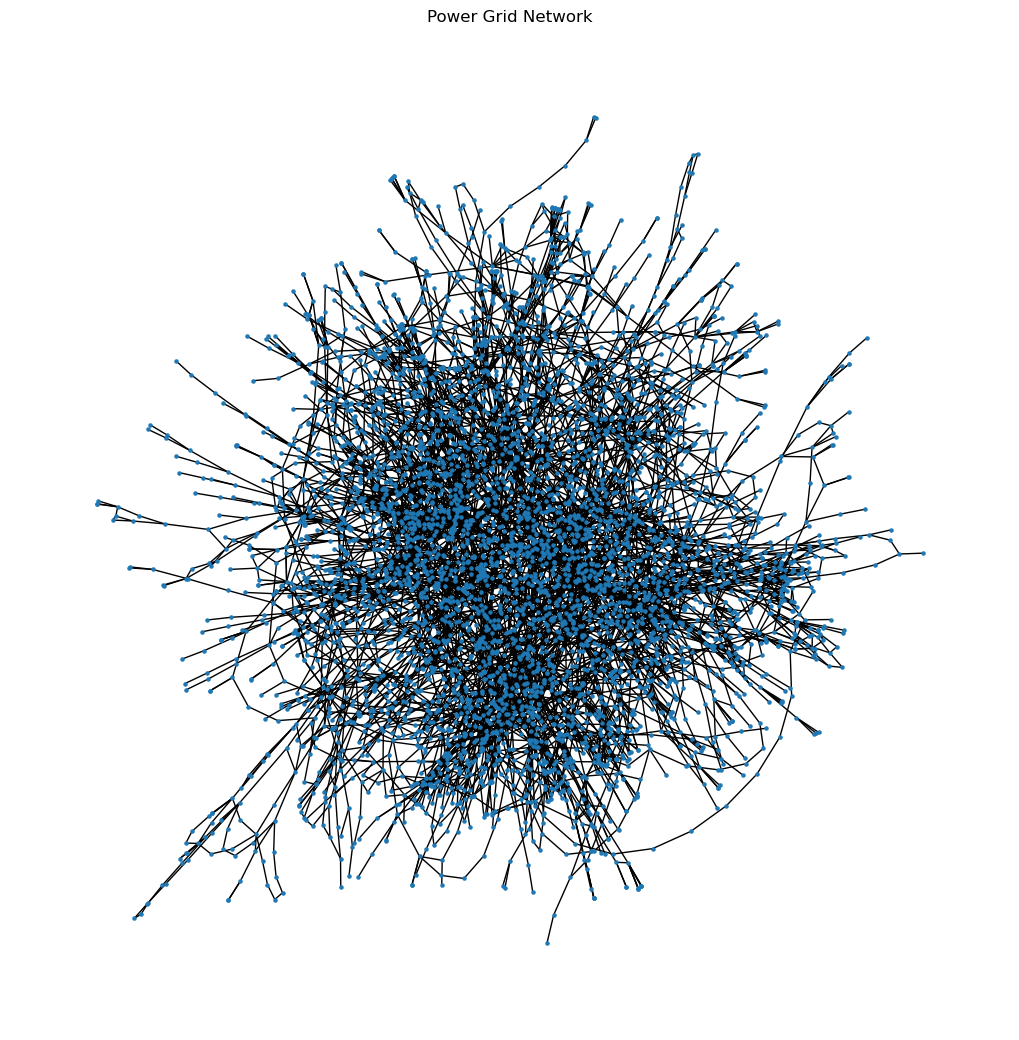

In [3]:
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=5)
plt.title("Power Grid Network")
plt.show()

The next interesting visualization in one that colors nodes based on their level of **betweenness centrality** metric. As we can see there is only a fraction of nodes with high values in this metric. Maximum score is **0.29** and majority of nodes has values close to **0.00**. This shows that the network is very dispersed and there is only a few major paths that contain fragments of the shortest paths of all the nodes.

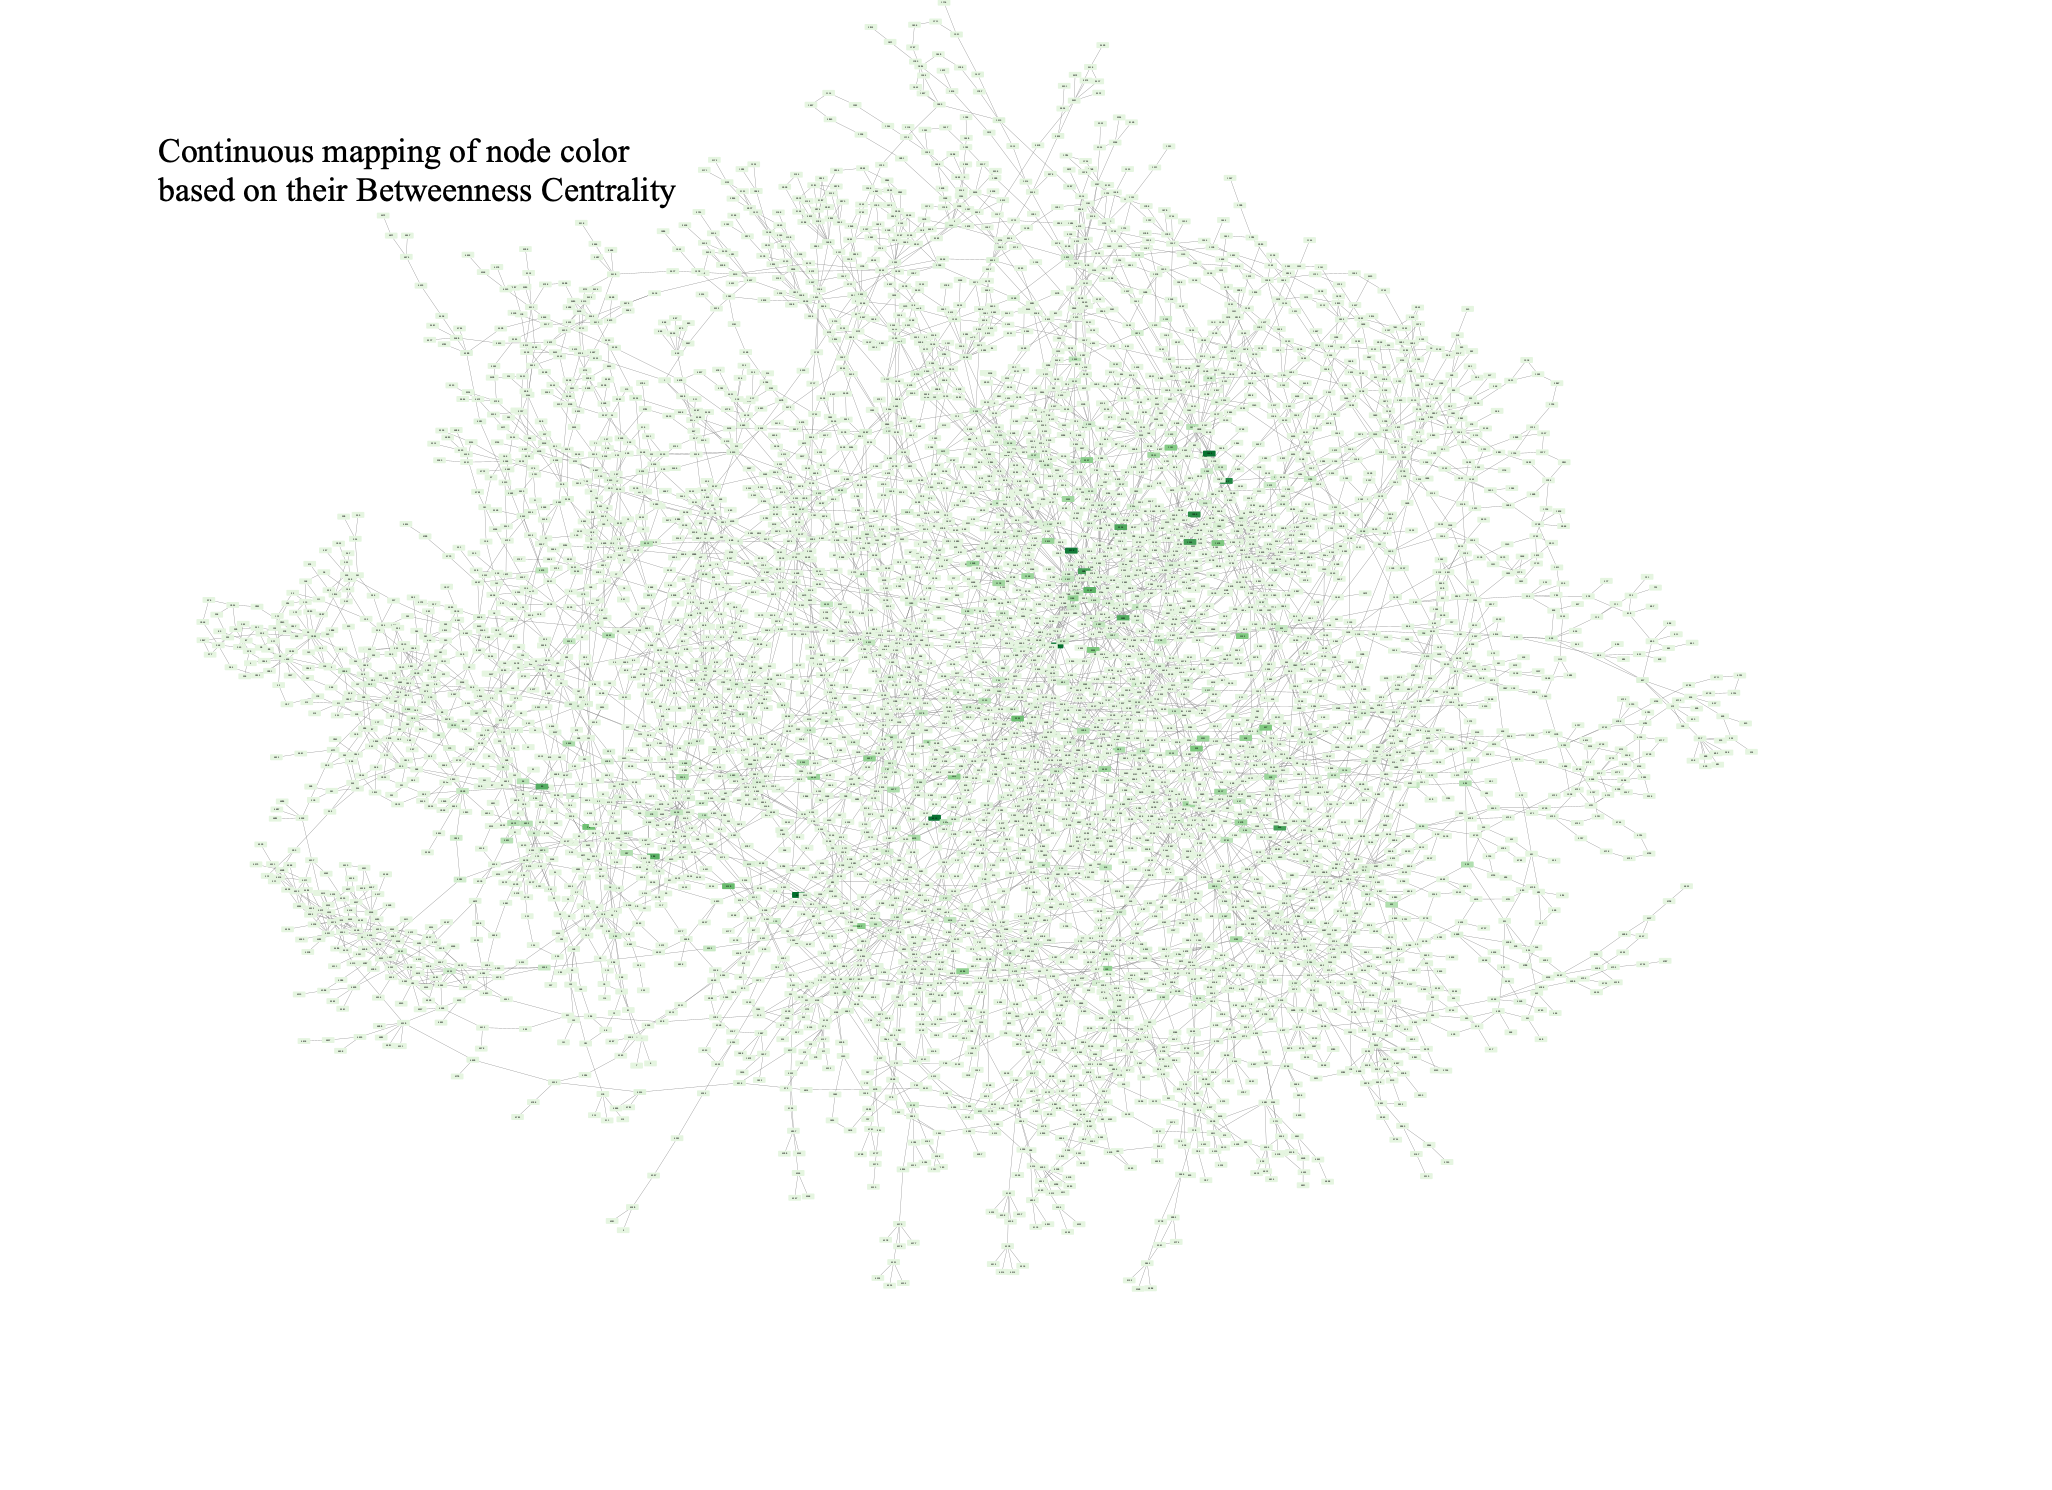

The final visualization involves color-coding nodes based on their **degree**. It reveals a distribution similar to that of the betweenness image, but less extreme. Most nodes exhibit low degrees, typically ranging from 1 to 3. These nodes primarily serve to deliver electricity to specific areas and are not considered pivotal in the network's operations. However, there is a notable presence of nodes with high degrees, which typically represent power plants or significant transmission poles connecting multiple electricity paths.

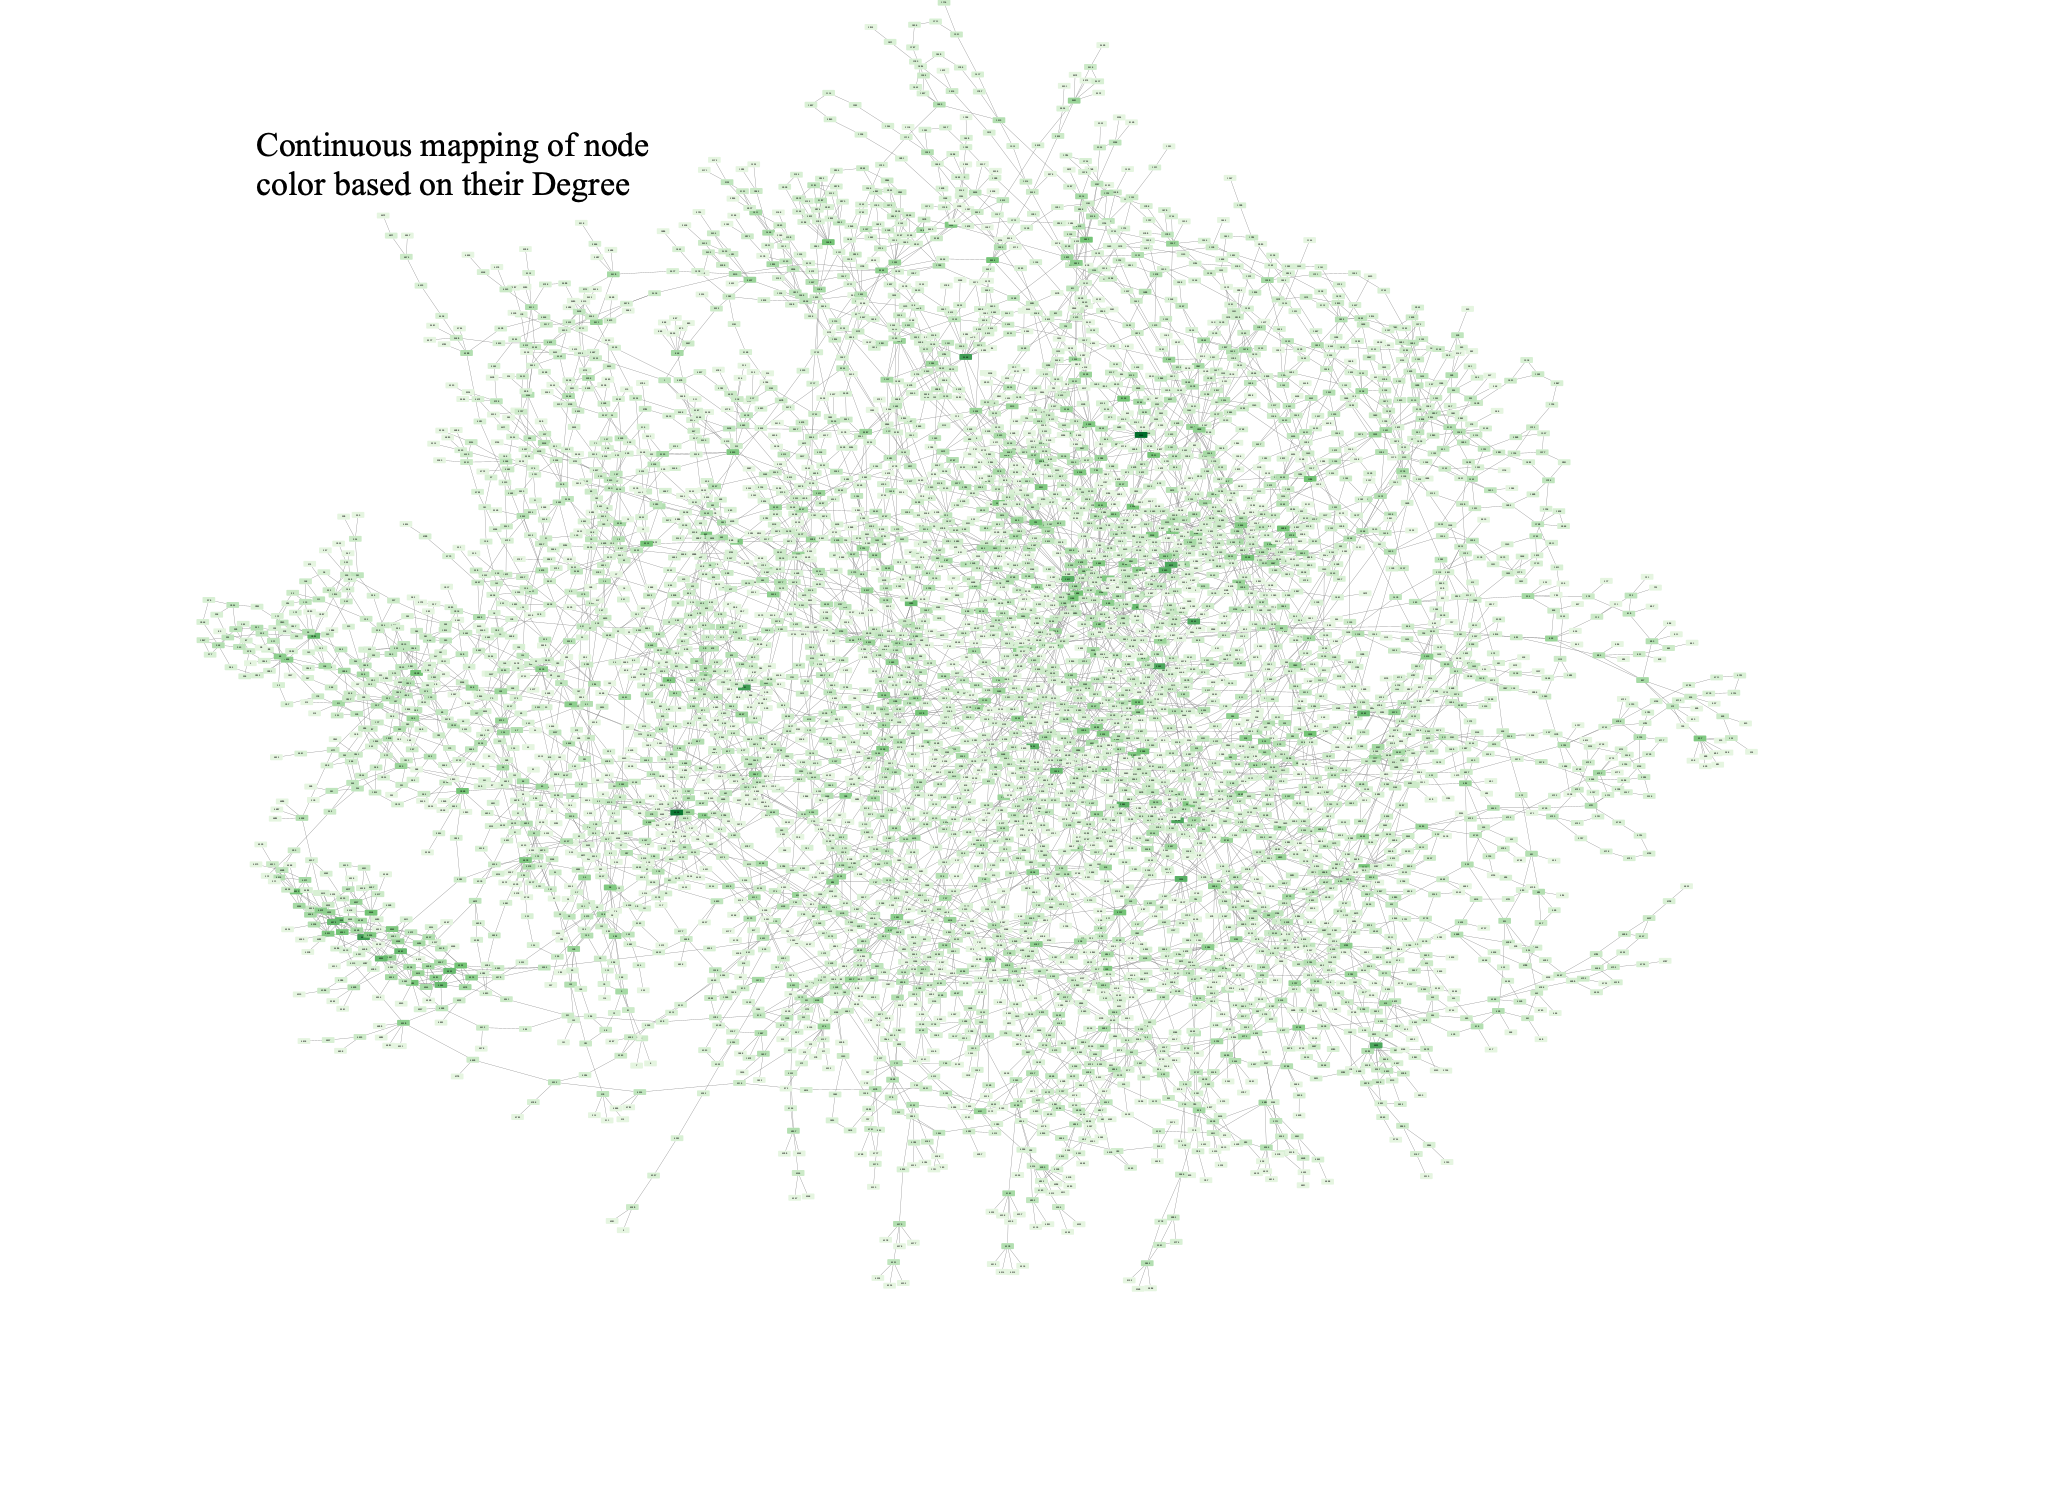

### 2.2 Community analysis (30%)



#### 2.3.1 Identifies the communities that appear in the network
To identify communities I've used the **Louvain Community Detection Algorithm** implemented in Networkx library. This is a heuristic method trying to find the best partition of a graph.

Algorithm distinguished **40 communities** in the Power Grid Network. As we can see on the chart below, the distribution of community size is dispersed. Size ranges **between 31 and 207 nodes**.

Number of communities: 40
Smallest community: 31
Largest community: 207


(array([2., 5., 3., 3., 5., 3., 9., 4., 2., 4.]),
 array([ 31. ,  48.6,  66.2,  83.8, 101.4, 119. , 136.6, 154.2, 171.8,
        189.4, 207. ]),
 <BarContainer object of 10 artists>)

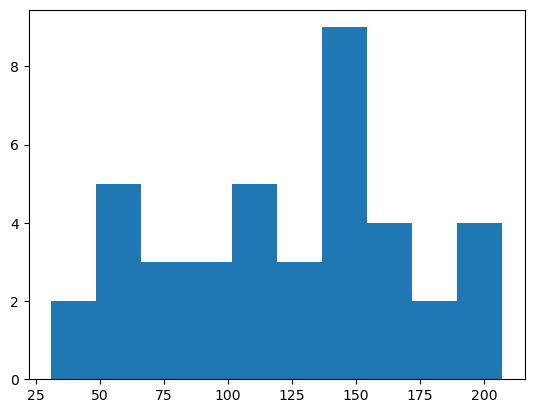

In [4]:
communities = nx_comm.louvain_communities(G, seed=0)
communities = [list(community) for community in communities]

partition_id = 0
for community in communities:
    for node in community:
        G.nodes[node]["partition_id"] = partition_id
    partition_id += 1

community_division = [[] for _ in range(len(communities))]

for node in G.nodes:
    community_division[G.nodes[node]["partition_id"]].append(node)

smallest_community = min(community_division, key=len)
largest_community = max(community_division, key=len)

print(f'Number of communities: {len(community_division)}')
print(f'Smallest community: {len(smallest_community)}')
print(f'Largest community: {len(largest_community)}')

node_colors = [G.nodes[node]["partition_id"] for node in G.nodes]
          
lengths = [len(community) for community in community_division]

plt.hist(lengths)

Below is the code that divides communities into discs on a plot. The algorithm generally performed well, as evidenced by the majority of communities. Take, for instance, Community 3, which comprises 104 connected nodes with only 6 edges connecting it to other communities. However, certain communities, such as Community 12, exhibit numerous connections to others, including Communities 8, 11, and 13.

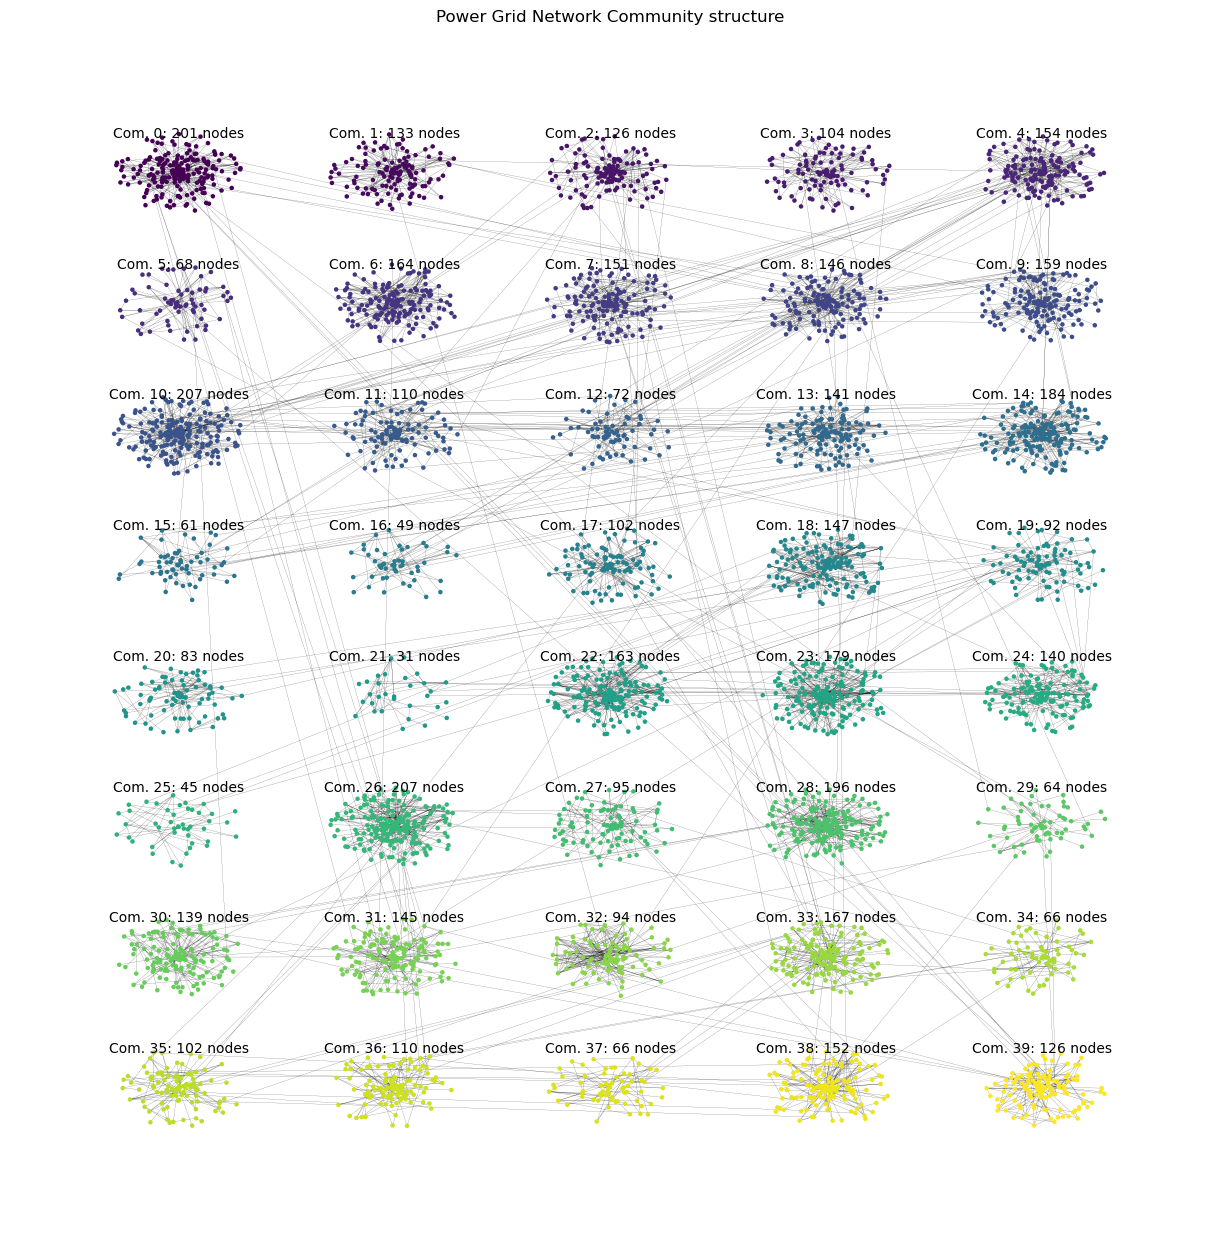

In [5]:
community_positions = {}
rows = 8
columns = 5  
spacing = 1
radius = 0.3

for i in range(rows):
    for j in range(columns):
        community_id = i * columns + j
        x = (j + 1) * spacing
        y = (rows - i) * spacing
        community_positions[community_id] = (x, y)

pos = {}

for node in G.nodes:
    community_id = G.nodes[node]["partition_id"]
    community_size = len(community_division[community_id])
    angle = 2 * np.pi * community_division[community_id].index(node) / community_size

    # Introduce a random offset to distribute nodes within the disc
    offset = np.random.uniform(0, radius)
    x = community_positions[community_id][0] + (radius - offset) * np.cos(angle)
    y = community_positions[community_id][1] + (radius - offset) * np.sin(angle)
    pos[node] = (x, y)

plt.figure(figsize=(12, 12))
nx.draw(G, pos=pos, node_color=node_colors, node_size=5, width=0.1)

# Display index of the rows and columns
for i in range(rows):
    for j in range(columns):
        community_id = i * columns + j
        community = communities[community_id]
        num_nodes = len(community)
        plt.text((j + 1) * spacing, (rows - i) * spacing + 0.3, f"Com. {community_id}: {num_nodes} nodes", ha='center', va='center')


plt.title('Power Grid Network Community structure')
plt.show()


Below I've calculated subgraph made from nodes in each community and plotted them on the image below.

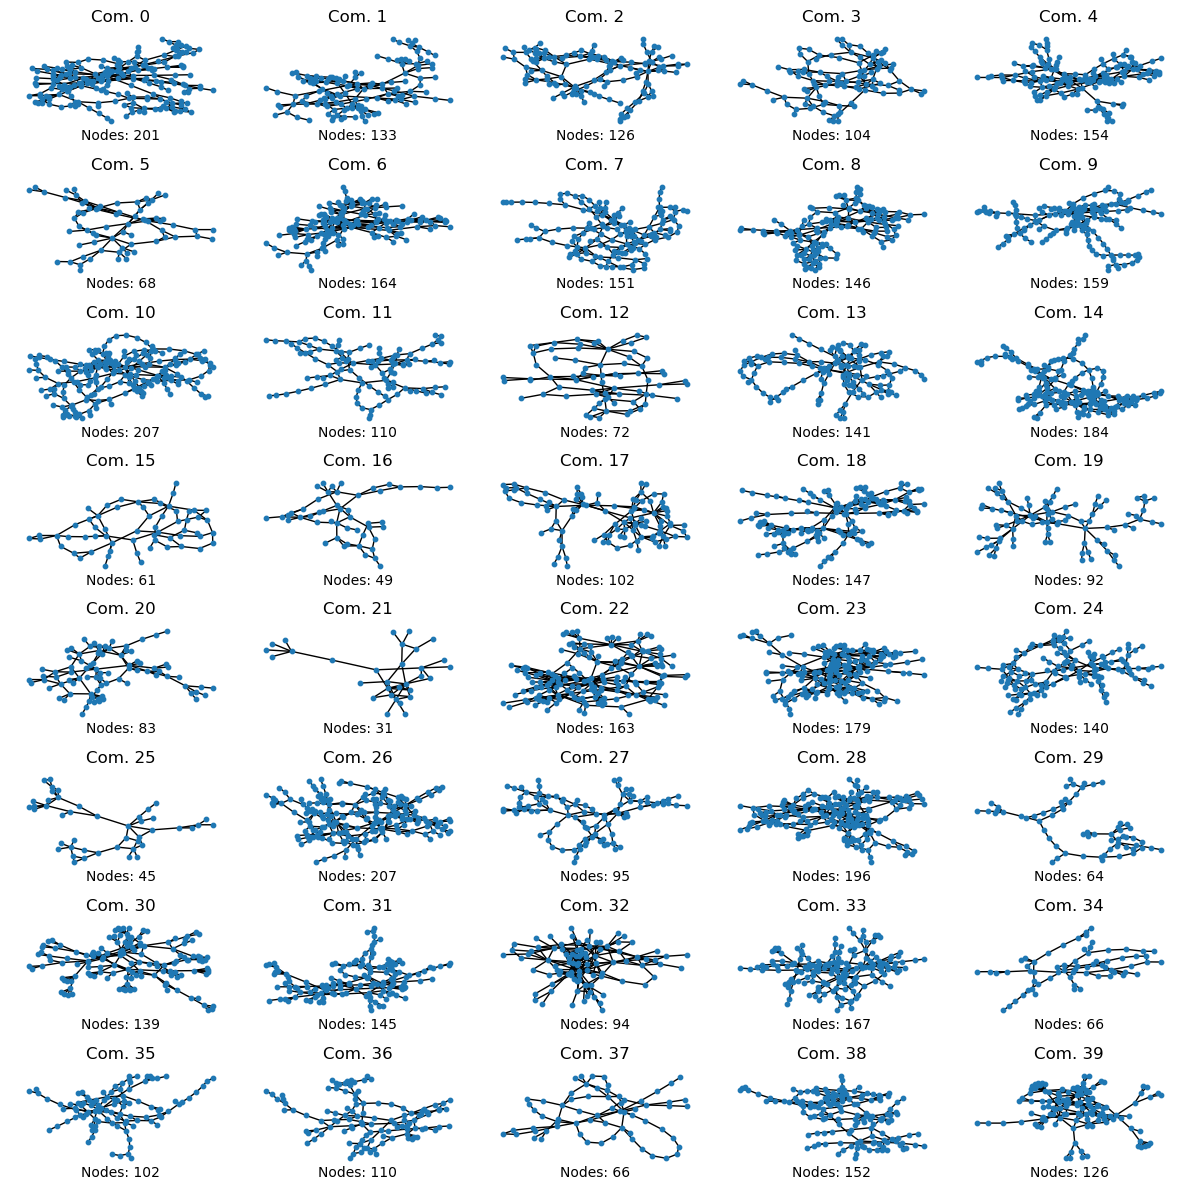

In [6]:
# Create subgraphs for each community
subgraphs = [G.subgraph(community) for community in communities]



# Plot communities and subgraphs in the same positions
fig, axes = plt.subplots(8, 5, figsize=(12, 12))

for i in range(rows * columns):
    col = i % columns
    row = i // columns

    # Draw the community
    community_id = i
    pos = {node: community_positions[community_id] for node in communities[community_id]}
    axes[row, col].set_title(f"Com. {community_id}")
    nx.draw(subgraphs[community_id], ax=axes[row, col], node_size=10)  
    axes[row, col].text(0.5, -0.1, f"Nodes: {len(communities[community_id])}", ha='center', transform=axes[row, col].transAxes)

plt.tight_layout()
plt.show()


#### 2.3.2 Describes the communities, explaining its meaning and the most relevant nodes in each group

To calculate the most relevant nodes in the graph I've used the approach from the first part of the project - but calculated all of the measures inside of the subgraphs.


In [7]:
centrality_dfs = []

for i, community in enumerate(communities):
    # Get the subgraph for the community
    subgraph = subgraphs[i].copy()

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(subgraph)

    # Calculate node degree
    node_degree = dict(subgraph.degree())

    # Calculate closeness centrality
    closeness_centrality = nx.closeness_centrality(subgraph)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(subgraph)

    # Calculate PageRank
    pagerank = nx.pagerank(subgraph)

    # Dataframe with all the values for the current community
    community_df = pd.DataFrame({
        'Node': list(subgraph.nodes()),
        'Degree': [degree_centrality[node] for node in subgraph.nodes()],
        'Closeness': [closeness_centrality[node] for node in subgraph.nodes()],
        'Betweenness': [betweenness_centrality[node] for node in subgraph.nodes()],
        'PageRank': [pagerank[node] for node in subgraph.nodes()],
        'Node_Degree': [node_degree[node] for node in subgraph.nodes()]
    })

    # Add a column for the community index
    community_df['Community'] = i

    centrality_dfs.append(community_df)

# Concatenate all DataFrames into one big DataFrame
centrality_df = pd.concat(centrality_dfs, ignore_index=True)

# Set the Node column as the index
centrality_df.set_index('Node', inplace=True)

columns_to_normalize = ['Degree', 'Closeness', 'Betweenness', 'PageRank', 'Node_Degree']

# Normalize the specified columns
min_val = 1
max_val = 10
centrality_df_normalized = centrality_df.copy()
for column in columns_to_normalize:
    centrality_df_normalized[column] = min_val + (centrality_df_normalized[column] - centrality_df_normalized[column].min()) * (max_val - min_val) / (centrality_df_normalized[column].max() - centrality_df_normalized[column].min())

centrality_df_normalized['Geometric_Average'] = np.power(centrality_df_normalized['Degree'] * centrality_df_normalized['Closeness'] * centrality_df_normalized['Betweenness'] * centrality_df_normalized['PageRank'] * centrality_df_normalized['Node_Degree'], 1/5)

top_10_nodes_normalized = centrality_df_normalized.sort_values(by='Geometric_Average', ascending=False).head(10)

avg_geometric_average = centrality_df_normalized['Geometric_Average'].mean()
median_geometric_average = centrality_df_normalized['Geometric_Average'].median()

print(f'Average geometric average in the dataset: {avg_geometric_average:.2f}')
print(f'Median geometric average in the dataset: {median_geometric_average:.2f}')

top_10_indexes = top_10_nodes_normalized.index

top_10_nodes = centrality_df.loc[top_10_indexes]


top_10_nodes_normalized


Average geometric average in the dataset: 1.82
Median geometric average in the dataset: 1.64


Degree  Closeness  Betweenness   PageRank  Node_Degree  Community  \
Node                                                                         
2851  10.000000  10.000000     6.365245  10.000000          5.5         21   
2852   8.173399   9.562478     6.445724   8.395326          4.5         21   
2604   4.603224   7.051003    10.000000   5.501966          3.5         25   
2382   4.393601   5.956244     6.557559   4.928167          7.0         17   
2553   4.080460   6.389166     5.332488   3.961531         10.0         22   
4345   4.991578   8.939780     3.585539   3.703647          7.5         32   
1361   4.291872   7.198322     7.584112   5.391009          3.5         16   
2694   5.433498   5.462200     4.541062   8.915671          3.0         21   
532    4.138519   5.855121     6.648741   4.878186          4.5          5   
4458   3.716493   5.703711     5.016308   4.690597          7.0         39   

      Geometric_Average  
Node                     
2851           8.106541  
2852           7.176273  
2604           5.743542  
2382           5.681510  
2553           5.600016  
4345           5.364904  
1361           5.359252  
2694           5.144888  
532            5.125288  
4458           5.112110

As we can see above average and median geometric average in the dataset is lower than values calculated for the whole dataset in the previous part of assignment. This comes from the fact that some communities are well-connected and overvalue the less well-connected communities. As we can see one particular Community that has 3 representatives in the top 10 nodes is Community 21. This community had the smallest size out of every distinguished community - only 31 nodes. Calculated geometric averages for nodes 2851 and 2852 are much higher than those calculated for the whole dataset (with previous maximum being only 6.41).

In [8]:
top_10_nodes

Degree  Closeness  Betweenness  PageRank  Node_Degree  Community
Node                                                                    
2851  0.333333   0.428571     0.383142  0.089150           10         21
2852  0.266667   0.410959     0.388889  0.073626            8         21
2604  0.136364   0.309859     0.642706  0.045637            6         25
2382  0.128713   0.265789     0.396875  0.040086           13         17
2553  0.117284   0.283217     0.309391  0.030735           19         22
4345  0.150538   0.385892     0.184638  0.028240           14         32
1361  0.125000   0.315789     0.470183  0.044563            6         16
2694  0.166667   0.245902     0.252874  0.078660            5         21
532   0.119403   0.261719     0.403387  0.039602            8          5
4458  0.104000   0.255624     0.286812  0.037788           13         39

One surprising fact is node **2553** that has a Node degree of **19**. This value is also the maximum value of the whole dataset. In this example the algorithm worked perfectly - it distinguished node with the highest degree in the whole dataset and created a community that contain every neightbour of Node **2553**.

In [9]:
# Get the index of the row with the highest value of Geometric Average for each community ID
highest_geometric_avg_idx = centrality_df_normalized.groupby('Community')['Geometric_Average'].idxmax()

# Use the index to get the corresponding rows from centrality_df_normalized
highest_geometric_avg_rows = centrality_df_normalized.loc[highest_geometric_avg_idx]

highest_geometric_avg_rows.sort_values(by='Geometric_Average', ascending=False)


Degree  Closeness  Betweenness   PageRank  Node_Degree  Community  \
Node                                                                         
2851  10.000000  10.000000     6.365245  10.000000          5.5         21   
2604   4.603224   7.051003    10.000000   5.501966          3.5         25   
2382   4.393601   5.956244     6.557559   4.928167          7.0         17   
2553   4.080460   6.389166     5.332488   3.961531         10.0         22   
4345   4.991578   8.939780     3.585539   3.703647          7.5         32   
1361   4.291872   7.198322     7.584112   5.391009          3.5         16   
532    4.138519   5.855121     6.648741   4.878186          4.5          5   
4458   3.716493   5.703711     5.016308   4.690597          7.0         39   
1460   4.340110   5.232789     5.265187   5.170723          5.0         12   
2585   3.306633   5.438968     7.337310   3.261895          7.0         18   
2493   3.540070   6.402089     6.266135   4.451192          4.5         20   
3310   3.198826   5.564009     7.510284   3.864828          4.5         27   
2282   3.058916   4.213080     7.174397   3.507205          5.5          2   
1309   2.836859   5.906651     6.187731   2.818169          6.0          4   
2542   2.868047   5.661462     5.281367   2.871549          7.0         23   
1005   2.945541   4.689955     6.254098   3.279837          6.0          8   
2593   2.673524   5.164884     8.818589   3.413719          3.5         19   
1554   2.628360   4.679528     7.308484   3.197311          5.0         13   
2409   3.396135   5.636504     5.206597   4.069435          3.5         37   
3468   2.729064   3.894313     4.231848   3.390397          7.5         26   
4029   2.729064   5.624895     5.946647   3.028842          4.0          3   
1622   3.150246   5.589994     5.248324   3.931491          3.0         15   
2522   2.246802   5.051601     9.342070   2.529889          4.0         24   
4172   2.256800   5.920928     7.089646   2.425837          4.0         30   
1091   2.254287   4.229355     8.143481   2.354326          4.5          9   
4106   3.476425   1.750280     7.847487   4.900447          3.5         29   
1334   2.197044   4.199606     6.079713   2.478856          5.5         10   
3895   2.693596   4.231872     3.294572   2.797950          7.0         28   
4878   2.500049   3.422032     5.435199   3.117103          5.0         38   
316    2.319973   5.076283     5.930701   2.492695          4.0          1   
4485   2.974612   3.729505     5.401835   3.868515          3.0         34   
1106   2.375198   4.491627     6.390542   2.902067          3.5         11   
725    2.547916   4.660532     3.694354   2.841218          5.5          6   
2249   2.187430   4.007908     6.462527   2.540175          4.5         33   
4867   2.494659   4.178615     5.524772   3.160117          3.5         35   
803    2.328276   4.058461     4.176326   2.686127          4.5          7   
1419   2.064766   4.020977     5.442278   2.297559          4.5         14   
129    2.198892   3.780829     4.638866   2.752780          4.0         31   
98     2.099951   3.426007     4.258634   2.451104          5.0          0   
4520   2.626565   2.487568     3.775598   3.746853          4.0         36   

      Geometric_Average  
Node                     
2851           8.106541  
2604           5.743542  
2382           5.681510  
2553           5.600016  
4345           5.364904  
1361           5.359252  
532            5.125288  
4458           5.112110  
1460           4.989233  
2585           4.963654  
2493           4.906869  
3310           4.712762  
2282           4.469462  
1309           4.454159  
2542           4.439101  
1005           4.426907  
2593           4.291093  
1554           4.280493  
2409           4.270023  
3468           4.089378  
4029           4.062070  
1622           4.050335  
2522           4.037566  
4172           3.914586  
1091           3.828552  
4106           3.825207  
1334

Above there is a list of the most relevant nodes in each group. As we can see most of the communities have low maximum values of Geometric_Average metric. This shows that only a few communities are in fact very well-connected.

### 2.3.3 Relates the community structure with the centrality measures

To properly measure the relevance of each community and relevance of their most important nodes I've calculated whether the Community is connected, how many nodes it has and following measures:
- highest and median betweenness,
- highest and median closenss,
- highest and median node degree.

In [10]:
community_data = pd.DataFrame(columns=['Community', 'Connected', 'Num_nodes', 'Median_betweenness', 'Highest_betweenness', 'Median_closeness', 'Highest_closeness','Average_degree', 'Highest_degree'])

# Iterate over each community
for i, community in enumerate(communities):
    # Get the subgraph for the community
    subgraph = subgraphs[i].copy()

    giant_component = max(nx.connected_components(subgraph), key=len)
    G_giant = G.subgraph(giant_component)

    connected = subgraph.number_of_nodes() == G_giant.number_of_nodes()

    if not connected:
        subgraph = G_giant
        
    # Calculate centrality measures for nodes in the giant component
    betweenness = nx.betweenness_centrality(subgraph)
    closeness = nx.closeness_centrality(subgraph)
    average_degree = 2 * subgraph.number_of_edges() / subgraph.number_of_nodes()
    highest_degree = max(dict(subgraph.degree()).values())
    
    # Calculate median and highest centrality measures
    median_betweenness = pd.Series(betweenness).median()
    highest_betweenness = max(betweenness.values())
    median_closeness = pd.Series(closeness).median()
    highest_closeness = max(closeness.values())
    
    # Check if the subgraph is fully connected
    fully_connected = nx.is_connected(subgraph)
    
    # Add the results to the DataFrame
    community_data = community_data.append({'Community': i, 
                                            'Connected': connected,
                                            'Num_nodes': len(giant_component), 
                                            'Median_betweenness': median_betweenness, 
                                            'Highest_betweenness': highest_betweenness, 
                                            'Median_closeness': median_closeness, 
                                            'Highest_closeness': highest_closeness, 
                                            'Average_degree': average_degree, 
                                            'Highest_degree': highest_degree}, 
                                                ignore_index=True)

community_data

Community Connected Num_nodes  Median_betweenness  Highest_betweenness  \
0          0      True       201            0.012798             0.277261   
1          1      True       133            0.015152             0.435512   
2          2      True       126            0.016908             0.478734   
3          3      True       104            0.019893             0.430557   
4          4      True       154            0.013518             0.376092   
5          5      True        68            0.041376             0.403387   
6          6      True       164            0.000606             0.495342   
7          7      True       151            0.018160             0.311295   
8          8      True       146            0.013793             0.398453   
9          9      True       159            0.016058             0.510129   
10        10      True       207            0.015495             0.362751   
11        11      True       110            0.030686             0.384948   
12        12      True        72            0.025922             0.517764   
13        13      True       141            0.015224             0.575943   
14        14      True       184            0.022776             0.317231   
15        15      True        61            0.044821             0.307542   
16        16      True        49            0.043765             0.470183   
17        17      True       102            0.014010             0.396875   
18        18      True       147            0.000331             0.577496   
19        19      True        92            0.021978             0.558339   
20        20      True        83            0.000000             0.376064   
21        21      True        31            0.000000             0.388889   
22        22      True       163            0.000038             0.391571   
23        23      True       179            0.000000             0.305740   
24        24      True       140            0.014388             0.595722   
25        25      True        45            0.000000             0.642706   
26        26      True       207            0.013005             0.230792   
27        27      True        95            0.021277             0.464911   
28        28      True       196            0.010311             0.266921   
29        29      True        64            0.047107             0.566308   
30        30      True       139            0.000000             0.434873   
31        31      True       145            0.013889             0.388007   
32        32      True        94            0.008657             0.184638   
33        33      True       167            0.019095             0.390089   
34        34      True        66            0.075962             0.314343   
35        35      True       102            0.037551             0.375317   
36        36      True       110            0.036527             0.310993   
37        37      True        66            0.041086             0.343333   
38        38      True       152            0.026313             0.414525   
39        39      True       126            0.015605             0.300609   

    Median_closeness  Highest_closeness  Average_degree Highest_degree  
0           0.128205           0.170358        2.497512              9  
1           0.153667           0.234043        2.676692              8  
2           0.146199           0.219684        2.571429             10  
3           0.168026           0.255583        2.519231              7  
4           0.171910           0.270318        2.935065             11  
5           0.203038           0.263780        2.705882              8  
6           0.151346           0.236575        2.439024             10  
7           0.140581           0.207756        2.543046              8  
8           0.162558           0.230525        2.835616             11  
9           0.122766           0.196273        2.427673              8  
10          0.126769           0.195076   

In [11]:
print(f"Average average degree in communities: {community_data['Average_degree'].mean()}")

Average average degree in communities: 2.5726912767419217


Calculated average node degree of **2.57** closely aligns with the average degree of the entire network, which stands at **2.67**. This suggests that the **algorithm effectively identified communities**, with only a small number of edges connecting them being removed, even though calculated Geometric_average metric suggested different thing.

In the physical context, this indicates that the Power Grid Network operates in a manner where electric infrastructure is primarily interconnected within its respective geographic areas. Cities are connected to one particular power plant and to other cities connected to the same power plant. While connections between communities are not highly prevalent, there still exists a significant number of them, as seen in communities 10 and 11. This ensures overall network's reliability in the event of an electric failure at a particular power plant.

Besides of this, we can see above the median and maximum values of betweenness and closeness are much higher than those measured in the whole network. It's understandable since communities are much smaller than the whole network. 

To support observation that Power Grid Network has a strong community structure, a calculated **Modularity** of as much as **0.94** is present below. 

In [12]:
partition_dict = {node: G.nodes[node]["partition_id"] for node in G.nodes}

modularity_value = modularity(G, [set(community) for community in community_division])

print(f"Modularity of the network: {modularity_value:.2f}")

Modularity of the network: 0.94


### 2.3 Dynamics (robustness, diffusion, or others) (30%)

#### 2.3.1 Robustness

In [13]:
start_time = time.time()

total_nodes = G.number_of_nodes()

G_copy = G.copy()

G_eff = []

xticks = []

# Remove 100 nodes 40 times
for _ in range(40):
    remove = [node for (node, val) in sorted(G_copy.degree(), key=lambda pair: pair[0])]
    G_eff.append(nx.global_efficiency(G_copy))
    xticks.append(total_nodes - G_copy.number_of_nodes())
    # remove the next random node
    for i in range(100):
        G_copy.remove_node(remove.pop(0))

print("Execution time:", time.time() - start_time, "seconds")

# Remove 50 nodes 10 times
for _ in range(10):
    remove = [node for (node, val) in sorted(G_copy.degree(), key=lambda pair: pair[0])]
    G_eff.append(nx.global_efficiency(G_copy))
    xticks.append(total_nodes - G_copy.number_of_nodes())
    # remove the next random node
    for i in range(50):
        G_copy.remove_node(remove.pop(0))

# Remove 1 node until the end of the nodes
while G_copy.number_of_nodes() > 1:
    remove = [node for (node, val) in sorted(G_copy.degree(), key=lambda pair: pair[0])]
    G_eff.append(nx.global_efficiency(G_copy))
    xticks.append(total_nodes - G_copy.number_of_nodes())
    G_copy.remove_node(remove.pop(0))

print("Total execution time:", time.time() - start_time, "seconds")


Execution time: 223.609845161438 seconds
Total execution time: 229.499587059021 seconds


Due to high computational cost and small differences in efficiency rating in the first 90% of node removals I've decided to compute the efficiency every 100 nodes for first 4000 removals and then every 50 nodes for next 500 removals. Then I calculate efficiency of the network in every iteration.

As we can see, efficiency doesn't drop significantly. However, as nodes are gradually removed the efficiency of the network starts to decrease. This decrease suggests that the removal of nodes disrupts the connectivity within the network, leading to longer path lengths between nodes and reduced overall efficiency. We can observe fluctuations in efficiency (e.g. between 2600 removed nodes to 3200 removed nodes efficiency goes up from 0.38 to 0.64), where the efficiency temporarily increases or exceeds its initial value. This often happens during the removal of nodes that act as bottlenecks or congestions within the network, leading to improving overall performance in the short term.


The observed increase in Power Gird network efficiency in the later stages of node removal is remarkable and suggests an intriguing phenomenon in network dynamics. Initially, as nodes are removed, the network efficiency gradually decreases, which aligns with the expected behavior of a network under stress or damage caused by node removal. However, at a certain point (after removing around 4600 nodes) there is a sudden spike in efficiency, indicating an anomalous event in the network dynamics. In the physical context, this increase appears paradoxical. It suggest that the network might function optimally with significantly fewer nodes, undermining the fundamental role of extensive electric infrastructure that ensures reliable electricity distribution to all residents.

0.3766566146539246 15.903779690897178


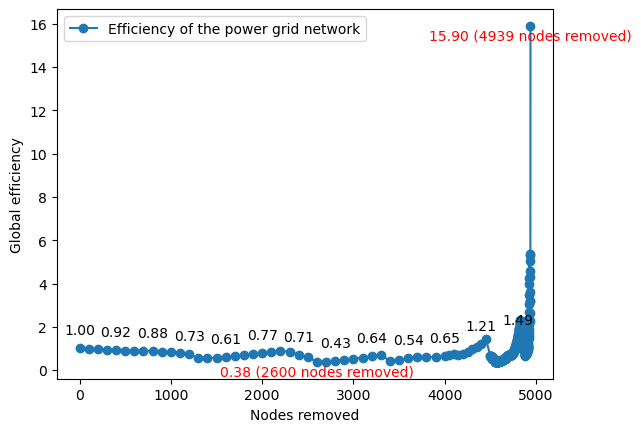

In [14]:
min_eff = min(G_eff) / G_eff[0]
max_eff = max(G_eff) / G_eff[0]

print(min_eff, max_eff)

plt.plot(xticks, np.array(G_eff) / G_eff[0], 'o-', label='Efficiency of the power grid network')

for idx, (x, y) in enumerate(zip(xticks, np.array(G_eff) / G_eff[0])):
    if y == min_eff or max_eff == y:
        plt.annotate(f'{y:.2f} ({x} nodes removed)', (x, y), textcoords="offset points", xytext=(0,-10), ha='center', color='red')
    elif x % 400 == 0:
        plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Nodes removed')
plt.ylabel('Global efficiency')
plt.legend()
plt.show()


As we can see the lowest observed efficiency is around **38%** of the initial value, while the highest efficiency reaches suprising level of **1590%** after the last removed node. 

### 2.3.2 Diffusion

To analyse difusion I've created a function that symulates SI model - mathematical model that  simulate how a disease (information etc.) evolves. It has 3 parameters:
- beta - chance of 'infection' in every iteration,
- firstly_infected - number of 'infected' nodes before first iteration,
- num_iterations - number of iterations, chances of the model.

In [15]:
def simulation(G, beta, firstly_infected, num_iterations):

    G_diffusion = G.copy()

    np.random.seed(42)

    initial_informed_nodes = np.random.choice(list(G_diffusion.nodes), firstly_infected)

    for node in G_diffusion.nodes:
        G_diffusion.nodes[node]["state"] = "S"
        
    for node in initial_informed_nodes:
        G_diffusion.nodes[node]["state"] = "I"

    community_positions = {}
    rows = 8
    columns = 5  
    spacing = 1
    radius = 0.3
    
    for i in range(rows):
        for j in range(columns):
            community_id = i * columns + j
            x = (j + 1) * spacing
            y = (rows - i) * spacing
            community_positions[community_id] = (x, y)

    pos = {}

    for node in G_diffusion.nodes:
        community_id = G_diffusion.nodes[node]["partition_id"]
        community_size = len(community_division[community_id])
        angle = 2 * np.pi * community_division[community_id].index(node) / community_size

        # Introduce a random offset to distribute nodes within the disc
        offset = np.random.uniform(0, radius)
        x = community_positions[community_id][0] + (radius - offset) * np.cos(angle)
        y = community_positions[community_id][1] + (radius - offset) * np.sin(angle)
        pos[node] = (x, y)
        
    num_rows = 3
    num_cols = 4
    visualization_iterations = num_iterations // (num_rows * num_cols)

    # Create a new figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Print the initial number of nodes
    initial_num_nodes = len(G_diffusion.nodes)
    print(f"Initial number of nodes: {initial_num_nodes}")

    # Iterate over each iteration
    for i in range(num_iterations):
        informed_nodes = [node for node in G_diffusion.nodes if G_diffusion.nodes[node]["state"] == "I"]

        for node in informed_nodes:
            neighbors = list(G_diffusion.neighbors(node))
            for neighbor in neighbors:
                if G_diffusion.nodes[neighbor]["state"] == "S":
                    number = np.random.random()
                    if number < beta:
                        G_diffusion.nodes[neighbor]["state"] = "I"

        if (i + 1) % visualization_iterations == 0:
            node_colors = [('green' if G_diffusion.nodes[node]['state'] == 'S' else 'red') for node in G_diffusion.nodes]

            # Plot the current state of the network
            ax = axes[(i // visualization_iterations) % (num_rows * num_cols)]
            nx.draw(G_diffusion, pos=pos, ax=ax, with_labels=False, node_color=node_colors, node_size=3, width=0.03)

            # Count the number of nodes with state "I"
            num_informed_nodes = len(informed_nodes)
            ax.text(0.1, -0.1, f"Nodes with state 'I': {num_informed_nodes}", transform=ax.transAxes)
            
            # Display the iteration number
            ax.set_title(f"Iteration {i+1}")

    # Set the title for the entire plot grid
    plt.suptitle(f"Diffusion simulation with beta={beta}, firstly_infected={firstly_infected} and {num_iterations} iterations.", fontsize=16)

    # Remove any empty plots
    for ax in axes[num_iterations:]:
        ax.remove()

    plt.tight_layout()
    plt.show()




#### Simulation 1

Initial number of nodes: 4941


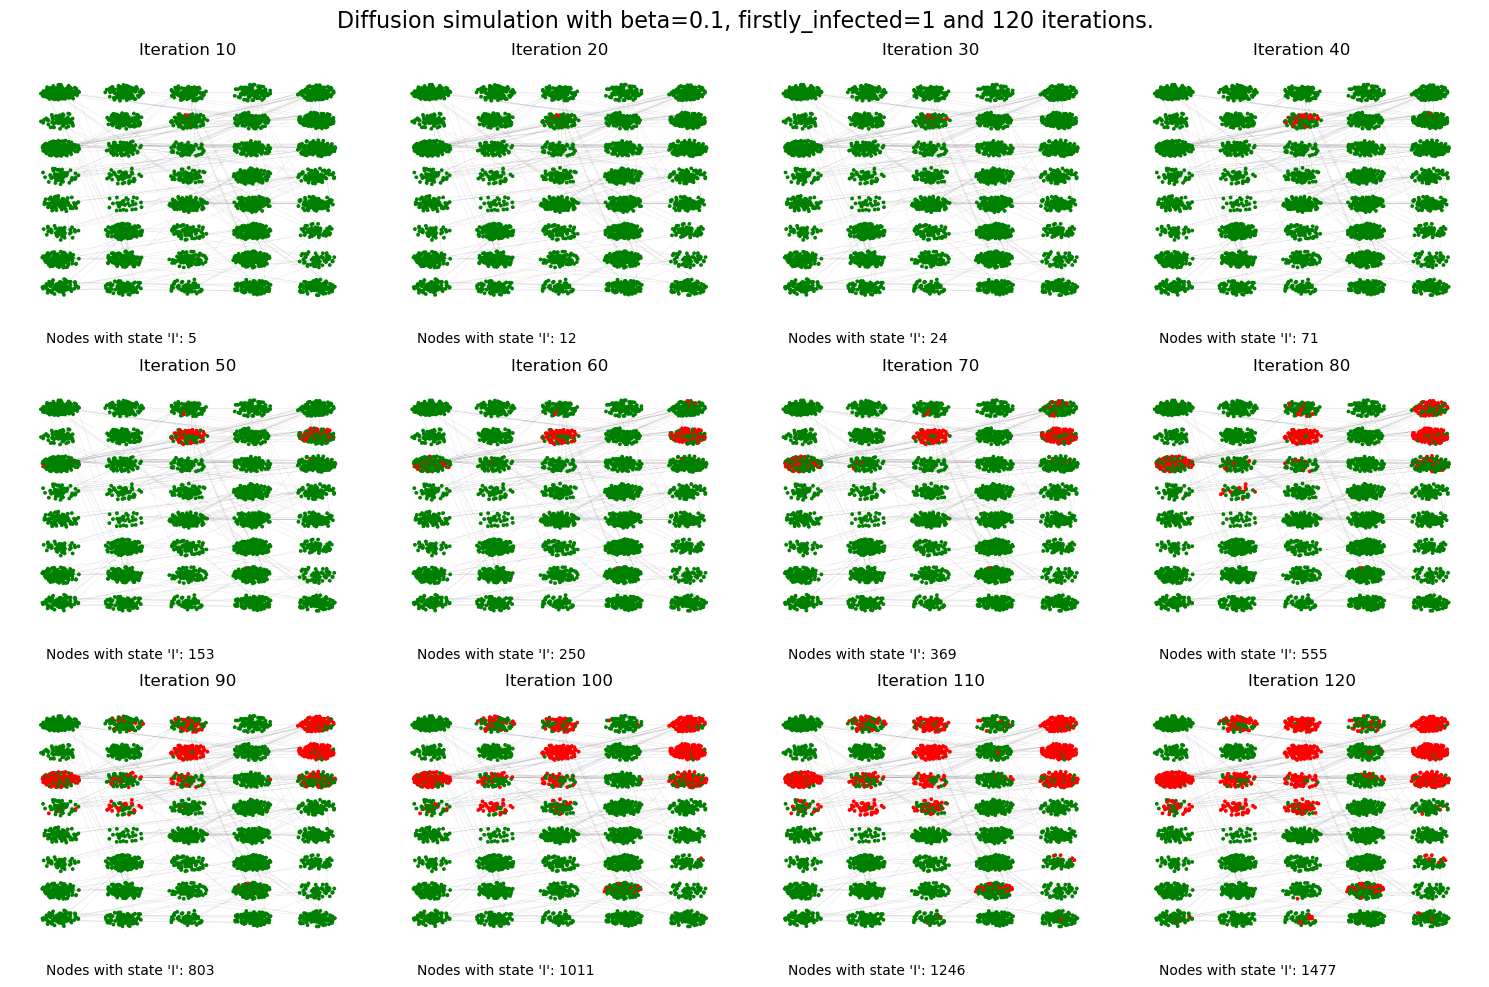

In [16]:
simulation(G, beta=0.1, firstly_infected=1, num_iterations=120)

The first simulation was conducted with the following parameters: 
- beta=0.1
- firstly_infected=1
- num_iterations=120.

It is presented on a plot above.

The observed diffusion initially occurs mostly within a single community before gradually spreading to others. Subsequently, propagation within these communities accelerates. Notably, due to the limited number of edges between certain communities, most of them remain uninfected during the whole simulation. Due to the low values of beta and firstly_infected, after 120 iterations, only 1477 out of the 4941 were infected.

#### Simulation 2

Initial number of nodes: 4941


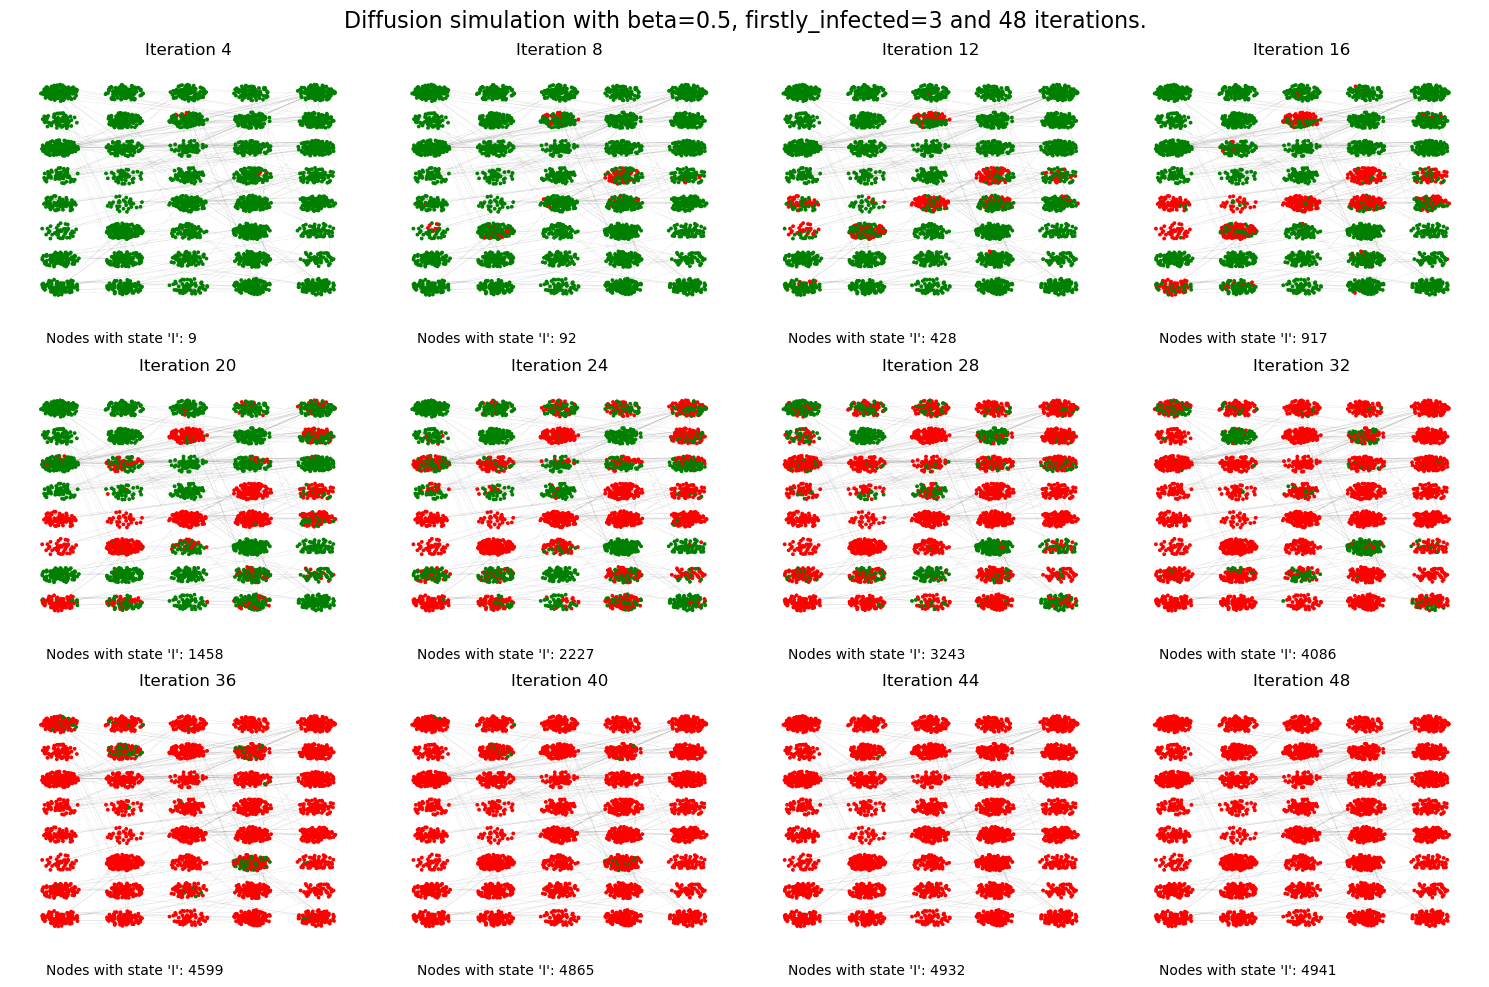

In [17]:
simulation(G, beta=0.5, firstly_infected=3, num_iterations=48)

The second simulation was conducted with the following parameters: 
- beta=0.5,
- firstly_infected=3,
- num_iterations=48.

It is presented on a plot above.

This parameter set reflects a more aggressive diffusion, with the beta parameter set to 0.5. As a result, every node becomes infected after 48 iterations. The number of infected nodes experiences the most significant increase between iterations 24 and 28, where over 1000 nodes become infected within just 4 iterations. During this period, many nodes alternate between being infected and uninfected, indicating the rapid spread of the diffusion. In contrast, the diffusion progresses more slowly during the last iterations, as the remaining nodes to be infected are typically located on the outskirts of the network and are less connected.

#### Simulation 3

Initial number of nodes: 4941


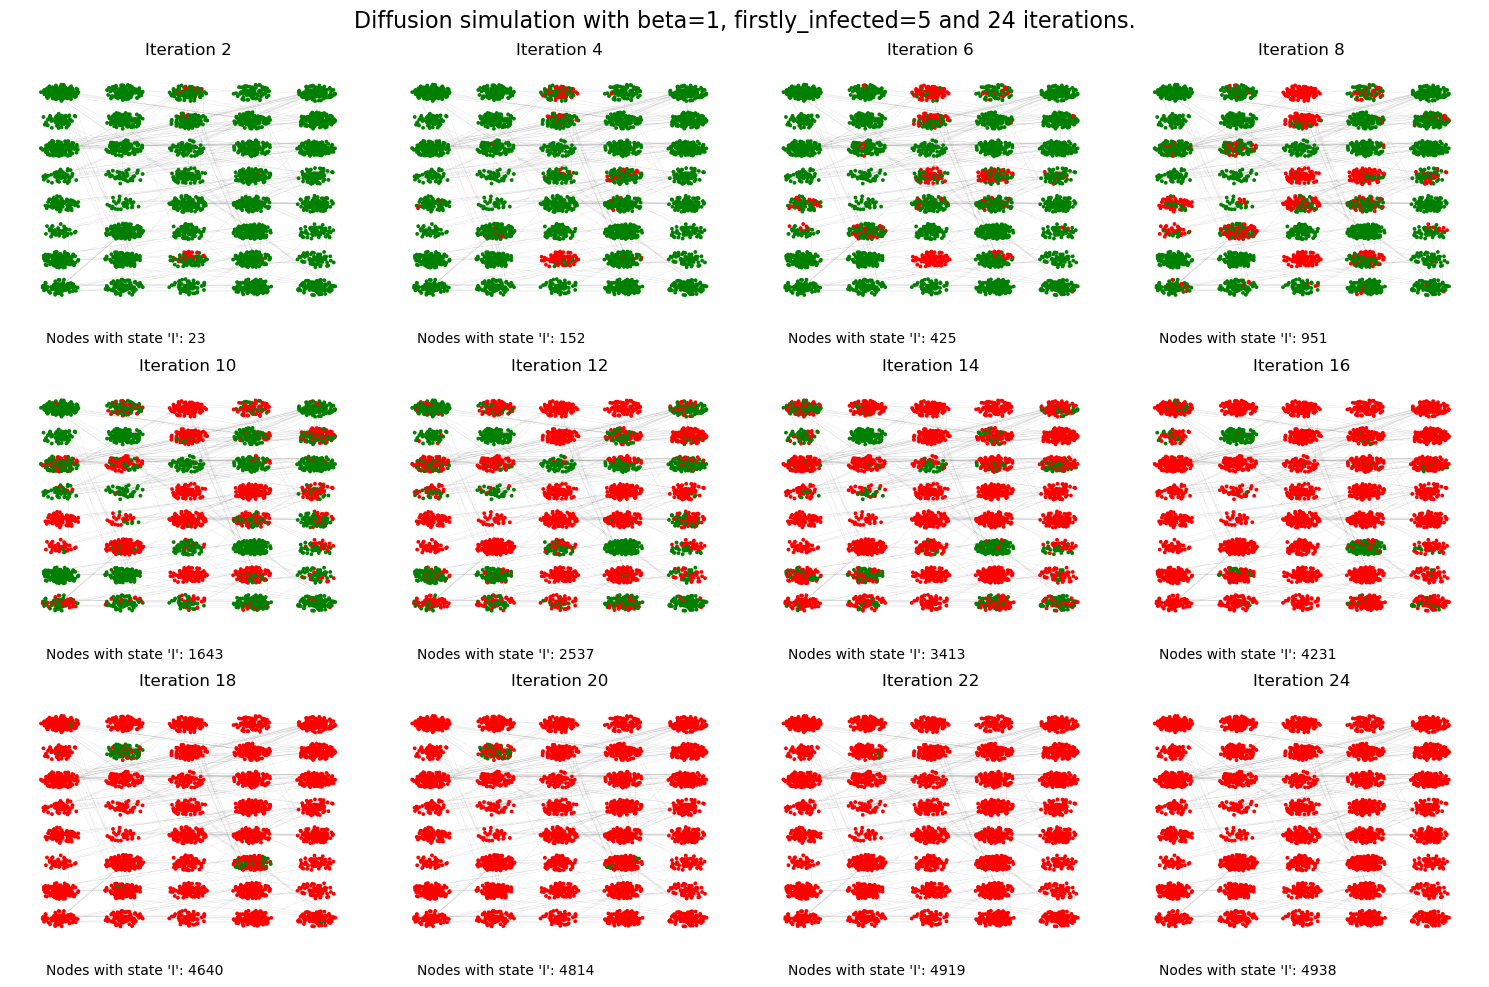

In [18]:
simulation(G, beta=1, firstly_infected=5, num_iterations=24)

The last simulation was conducted with the following parameters: 
- beta=1,
- firstly_infected=5,
- num_iterations=24.

It is presented on a plot above.

The last set of parameters reflects the most aggresive diffusion - with 100% probability of infection. As we can see diffusion works fast between communities. However, high diameter of the network (46) resulted in 3 nodes not being infected after the last interation.

In diffusions with lower values of beta, transmission between communities was challenging due to the limited number of edges connecting them.

In each simulation, there were nodes that remained unreachable until the final iterations or were never reached at all. This difficulty arises from the high average path length of the network (18.99) and its considerable diameter (46). Despite other parameters potentially being high, the distance between specific pairs of nodes was too great to be covered within the specified number of iterations.

### 2.4 Conclusions (10%)
#### Summarize the findings that you have obtained analyzing the network.

After the analysis of the Power Grid Network there are several notable findings:

- **Limited Critical Nodes**: Analysis of the centrality measures in the Power Grid Network suggests that there is only a fraction of nodes with high centrality measures. Most of the nodes are not considered important in the global context of the network - they are only important in their particular local areas. However, there is a notable presence of nodes with high degrees, which typically represent power plants or significant transmission poles connecting multiple electricity paths.

- **Small Average Node Degree**: With value of only 2.67 it suggest moderate level of connectivity of the electric structure. It is not required that the vertices are firmly connected - in the event of a failure, 1 or 2 additional spreading options are sufficient. By keeping the average node degree this low, the state guarantees a well-functioning network without spending huge costs to connect all pairs of infrastructure.

- **Degree Distribution**: Unsual degree distribution of Power Grid Network cannot be compared to any of the most known degree distributions of social networks (Poission, Binomial or Power Law Curve). The Power Grid Network is different because of its unique requirements.

- **Spread Nature** - Power Grid network is strongly based in a geographical context - this infrastrucre is spread on a more than 2000 km long coast. It presents high value of average path length of 18.99 and diameter of 46. 

- **Community Structure**: The network exhibits a clear community structure, with nodes grouped into distinct communities. The Louvain algorithm effectively identified these communities, with **Modularity** score of **0.94**. This is also supported by the observation of the generated graphs and counted metrics - most of the network edges exist within the community. In the physical context, infrastructure is mostly interconnected within its respective geographic areas.

- **High Robustness**: The Network was resistant to the removal of most nodes, confirming its reliability.

- **Diffusion Dynamics**: Diffusion simulations highlighted challenges in transmitting information or influence between communities, particularly when using lower values of the beta parameter. The network's high average path length and diameter contributed to difficulties in reaching certain nodes within specified iteration limits.

Even though Power Grid Network may have seemed not complicated on the first glance - with 4941 nodes there are only 6594 edges, the analysis above suggest opposite thing. In fact, this network is extremely carefully prepared; it is, after all, the foundation of a well-functioning country. Its structure provides electricity to all corners of the West Coast in an exceptionally reliable way.  
